In [1]:
import numpy as np
import math
from scipy.sparse import csr_matrix
import dimod
from neal import SimulatedAnnealingSampler
from typing import Dict, Tuple, List, Union

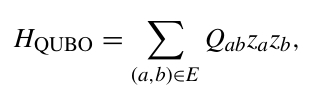

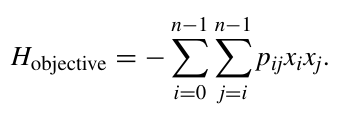

### CONSTRAINTS FOR DIFF ENCODINGS:

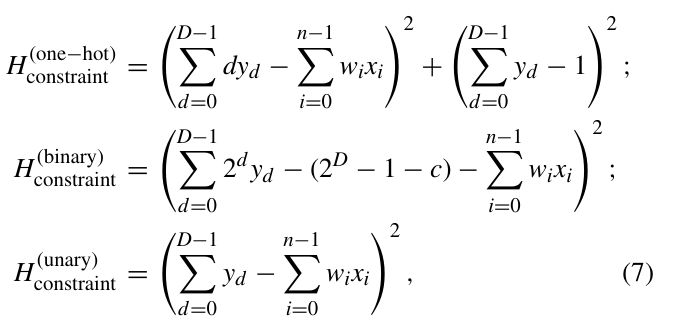

In [2]:
def generate_qkp_instance(n = 20, c = 30):
    weights = np.random.randint(1, 11, size = n)

    P = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                P[i, j] = np.random.randint(0, 11)  # Diagonal profits
            else:
                P[i, j] = np.random.randint(0, 11)  # Off-diagonal profits
    
    return weights, P

### Generate QKP with following Params:
- Total 50 items
- Weights randomly selected from 1 to 10
- Knapsack Capacity = 100

In [3]:
items = 50
capacity = 100
weights, P = generate_qkp_instance(n = items, c = capacity)

### QUBO FORMULATION

In [4]:
class QKPQUBOFormulator:
    """
    Quadratic Knapsack Problem (QKP) QUBO formulations using different binary-integer encodings.
    
    Based on the paper: "Performance Comparison of Typical Binary-Integer Encodings in an Ising Machine"
    by Tamura et al.
    """
    
    def __init__(self, weights: List[float], profits: np.ndarray, capacity: float):
        """
        Initialize the QKP instance.
        
        Args:
            weights: List of item weights [w0, w1, ..., w_{n-1}]
            profits: n×n matrix where profits[i][j] is profit for selecting items i and j
                    (profits[i][i] is profit for selecting item i alone)
            capacity: Knapsack capacity c
        """
        self.weights = np.array(weights)
        self.profits = np.array(profits)
        self.capacity = capacity
        self.n = len(weights)
        
        # Validate inputs
        assert self.profits.shape == (self.n, self.n), "Profits matrix must be n×n"
        assert capacity > 0, "Capacity must be positive"
        
    def _get_encoding_params(self, encoding_type: str) -> Tuple[int, callable]:
        """Get bit depth D and encoding function f(d) for each encoding type."""
        if encoding_type == "one_hot":
            D = int(self.capacity) + 1
            f = lambda d: d
        elif encoding_type == "binary":
            D = math.ceil(math.log2(self.capacity)) if self.capacity > 1 else 1
            f = lambda d: 2**d
        elif encoding_type == "unary":
            D = int(self.capacity)
            f = lambda d: 1
        else:
            raise ValueError("encoding_type must be 'one_hot', 'binary', or 'unary'")
        
        return D, f
    
    def get_variable_count(self, encoding_type: str) -> int:
        """Get total number of binary variables N = n + D."""
        D, _ = self._get_encoding_params(encoding_type)
        return self.n + D
    
    def formulate_qubo(self, encoding_type: str, A: float = 1.0) -> Tuple[np.ndarray, Dict]:
        """
        Formulate the QUBO matrix for the given encoding type.
        
        Args:
            encoding_type: 'one_hot', 'binary', or 'unary'
            A: Constraint penalty parameter
            
        Returns:
            Q: QUBO matrix
            var_info: Dictionary with variable information
        """
        D, f = self._get_encoding_params(encoding_type)
        N = self.n + D  # Total number of variables
        
        # Initialize QUBO matrix
        Q = np.zeros((N, N))
        
        # Variable mapping: x_0, x_1, ..., x_{n-1}, y_0, y_1, ..., y_{D-1}
        var_info = {
            'n_items': self.n,
            'bit_depth': D,
            'total_vars': N,
            'x_indices': list(range(self.n)),
            'y_indices': list(range(self.n, N)),
            'encoding_type': encoding_type
        }
        
        # Add objective function: -∑∑ p_{ij} x_i x_j
        for i in range(self.n):
            for j in range(i, self.n):
                if i == j:
                    Q[i, i] -= self.profits[i, i]
                else:
                    Q[i, j] -= self.profits[i, j]
        
        # Add constraint based on encoding type
        if encoding_type == "one_hot":
            self._add_one_hot_constraint(Q, A, D, f)
        elif encoding_type == "binary":
            self._add_binary_constraint(Q, A, D, f)
        elif encoding_type == "unary":
            self._add_unary_constraint(Q, A, D, f)
        
        print(f"For {encoding_type}, size = {Q.shape[0]}")
        return Q, var_info
    
    def _add_one_hot_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add one-hot encoding constraint terms to QUBO matrix."""
        # Constraint: (∑ d*y_d - ∑ w_i*x_i)² + (∑ y_d - 1)²
        
        # First term: (∑ d*y_d - ∑ w_i*x_i)²
        # = (∑ d*y_d)² - 2*(∑ d*y_d)*(∑ w_i*x_i) + (∑ w_i*x_i)²
        
        # (∑ d*y_d)² terms
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A * (f(d1)**2)
                else:
                    Q[y1_idx, y2_idx] += A * f(d1) * f(d2)
        
        # -2*(∑ d*y_d)*(∑ w_i*x_i) terms
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * f(d) * self.weights[i])
        
        # (∑ w_i*x_i)² terms
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]
        
        # Second term: (∑ y_d - 1)² = (∑ y_d)² - 2*(∑ y_d) + 1
        # (∑ y_d)² terms
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A
                else:
                    Q[y1_idx, y2_idx] += A
        
        # -2*(∑ y_d) terms (linear terms go on diagonal)
        for d in range(D):
            y_idx = self.n + d
            Q[y_idx, y_idx] += A * (-2)
        
        # Constant term +1 is not included in QUBO matrix
    
    def _add_binary_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add binary encoding constraint terms to QUBO matrix."""
        # Constraint: (∑ 2^d*y_d - (2^D - 1 - c) - ∑ w_i*x_i)²
        
        offset = 2**D - 1 - self.capacity
        
        # (∑ 2^d*y_d)² terms
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A * (f(d1)**2)
                else:
                    Q[y1_idx, y2_idx] += A * f(d1) * f(d2)
        
        # -2*(∑ 2^d*y_d)*offset terms
        for d in range(D):
            y_idx = self.n + d
            Q[y_idx, y_idx] += A * (-2 * f(d) * offset)
        
        # -2*(∑ 2^d*y_d)*(∑ w_i*x_i) terms
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * f(d) * self.weights[i])
        
        # +2*offset*(∑ w_i*x_i) terms
        for i in range(self.n):
            Q[i, i] += A * (2 * offset * self.weights[i])
        
        # (∑ w_i*x_i)² terms
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]
        
        # offset² is a constant term (not included in QUBO matrix)
    
    def _add_unary_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add unary encoding constraint terms to QUBO matrix."""
        # Constraint: (∑ y_d - ∑ w_i*x_i)²
        
        # (∑ y_d)² terms
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A
                else:
                    Q[y1_idx, y2_idx] += A
        
        # -2*(∑ y_d)*(∑ w_i*x_i) terms
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * self.weights[i])
        
        # (∑ w_i*x_i)² terms
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]

In [5]:
class QUBOToBQMConverter:
    """
    Convert QUBO matrices to D-Wave dimod Binary Quadratic Models (BQMs).
    """
    
    @staticmethod
    def qubo_matrix_to_bqm(Q: np.ndarray, var_info: Dict, 
                          variable_names: List[str] = None) -> dimod.BinaryQuadraticModel:
        """
        Convert a QUBO matrix to a dimod BQM.
        
        Args:
            Q: QUBO matrix (can be full or upper triangular)
            var_info: Variable information from QKP formulator
            variable_names: Optional list of variable names
            
        Returns:
            dimod.BinaryQuadraticModel
        """
        n = Q.shape[0]
        
        # Create variable names if not provided
        if variable_names is None:
            variable_names = []
            # Item variables
            for i in range(var_info['n_items']):
                variable_names.append(f"x{i}")
            # Auxiliary variables  
            for i in range(var_info['bit_depth']):
                variable_names.append(f"y{i}")
        
        # Extract linear and quadratic terms
        linear = {}
        quadratic = {}
        
        for i in range(n):
            # Linear terms (diagonal)
            if Q[i, i] != 0:
                linear[variable_names[i]] = Q[i, i]
                
            # Quadratic terms (upper triangle)
            for j in range(i + 1, n):
                coeff = Q[i, j] + Q[j, i]  # Combine symmetric elements
                if coeff != 0:
                    quadratic[(variable_names[i], variable_names[j])] = coeff
        
        # Create BQM
        bqm = dimod.BinaryQuadraticModel(linear, quadratic, 'BINARY')
        return bqm
    
    @staticmethod
    def qubo_dict_to_bqm(qubo_dict: Dict[Tuple, float]) -> dimod.BinaryQuadraticModel:
        """
        Convert a QUBO dictionary to a dimod BQM.
        
        Args:
            qubo_dict: Dictionary with (i,j) tuples as keys and coefficients as values
            
        Returns:
            dimod.BinaryQuadraticModel
        """
        return dimod.BinaryQuadraticModel.from_qubo(qubo_dict)
    
    @staticmethod
    def matrix_to_qubo_dict(Q: np.ndarray, var_info: Dict, 
                           variable_names: List[str] = None) -> Dict[Tuple, float]:
        """
        Convert QUBO matrix to QUBO dictionary format.
        
        Args:
            Q: QUBO matrix
            var_info: Variable information
            variable_names: Optional variable names
            
        Returns:
            Dictionary with (var1, var2) tuples as keys
        """
        n = Q.shape[0]
        
        # Create variable names if not provided
        if variable_names is None:
            variable_names = []
            for i in range(var_info['n_items']):
                variable_names.append(f"x{i}")
            for i in range(var_info['bit_depth']):
                variable_names.append(f"y{i}")
        
        qubo_dict = {}
        
        for i in range(n):
            for j in range(i, n):  # Upper triangular including diagonal
                coeff = Q[i, j]
                if j > i:
                    coeff += Q[j, i]  # Add symmetric part for off-diagonal
                
                if coeff != 0:
                    qubo_dict[(variable_names[i], variable_names[j])] = coeff
        
        return qubo_dict

In [6]:
def enhanced_qubo_formulator():
    """
    Enhanced version of the QKP formulator with BQM conversion methods.
    """
    
    class QKPQUBOFormulatorWithBQM(QKPQUBOFormulator):
        def to_bqm(self, encoding_type: str, A: float = 1.0, 
                  variable_names: List[str] = None) -> dimod.BinaryQuadraticModel:
            """Generate BQM directly from the formulation."""
            Q, var_info = self.formulate_qubo(encoding_type, A)
            converter = QUBOToBQMConverter()
            return converter.qubo_matrix_to_bqm(Q, var_info, variable_names)
        
        def to_qubo_dict(self, encoding_type: str, A: float = 1.0,
                        variable_names: List[str] = None) -> Dict[Tuple, float]:
            """Generate QUBO dictionary directly from the formulation."""
            Q, var_info = self.formulate_qubo(encoding_type, A)
            converter = QUBOToBQMConverter()
            return converter.matrix_to_qubo_dict(Q, var_info, variable_names)
    
    return QKPQUBOFormulatorWithBQM

In [7]:
quboGenerator = enhanced_qubo_formulator()
formulator = quboGenerator(weights, profits = P, capacity = capacity)
bqms = {
    "unary" : None,
    "binary" : None,
    "one_hot" : None
}

for encoding in ["unary", "binary", "one_hot"]:
    bqm = formulator.to_bqm(encoding, A = 100)
    bqms[encoding] = bqm

For unary, size = 150
For binary, size = 57
For one_hot, size = 151


In [8]:
results = {
    "unary" : [],
    "binary" : [],
    "one_hot" : []
}

In [9]:
from neal import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()
for i in range(25):
    for encoding in ["unary", "binary", "one_hot"]:
        sampleset = sampler.sample(bqms[encoding], num_reads= 1000)
        results[encoding].append(sampleset.first.energy)
    print(f"{i} Iteration(s) Done")
    continue

0th Iteration Done
1th Iteration Done
2th Iteration Done
3th Iteration Done
4th Iteration Done
5th Iteration Done
6th Iteration Done
7th Iteration Done
8th Iteration Done
9th Iteration Done
10th Iteration Done
11th Iteration Done
12th Iteration Done
13th Iteration Done
14th Iteration Done
15th Iteration Done
16th Iteration Done
17th Iteration Done
18th Iteration Done
19th Iteration Done
20th Iteration Done
21th Iteration Done
22th Iteration Done
23th Iteration Done
24th Iteration Done


In [14]:
unaryEnergies = np.array(results["unary"])
binaryEnergies = np.array(results["binary"])
one_hotEnergies = np.array(results["one_hot"])

In [15]:
np.mean(unaryEnergies), np.std(unaryEnergies)

(np.float64(-1344.0), np.float64(33.544000953970894))

In [16]:
np.mean(one_hotEnergies), np.std(one_hotEnergies)

(np.float64(-2641.0), np.float64(263.3028674359624))

In [17]:
np.mean(binaryEnergies), np.std(binaryEnergies)

(np.float64(-74772.76), np.float64(71.01001619490027))

In [18]:
results

{'unary': [np.float64(-1411.0),
  np.float64(-1322.0),
  np.float64(-1396.0),
  np.float64(-1333.0),
  np.float64(-1349.0),
  np.float64(-1347.0),
  np.float64(-1345.0),
  np.float64(-1386.0),
  np.float64(-1354.0),
  np.float64(-1327.0),
  np.float64(-1345.0),
  np.float64(-1300.0),
  np.float64(-1327.0),
  np.float64(-1335.0),
  np.float64(-1376.0),
  np.float64(-1281.0),
  np.float64(-1363.0),
  np.float64(-1357.0),
  np.float64(-1341.0),
  np.float64(-1367.0),
  np.float64(-1291.0),
  np.float64(-1370.0),
  np.float64(-1385.0),
  np.float64(-1297.0),
  np.float64(-1295.0)],
 'binary': [np.float64(-74800.0),
  np.float64(-75008.0),
  np.float64(-74726.0),
  np.float64(-74786.0),
  np.float64(-74715.0),
  np.float64(-74707.0),
  np.float64(-74757.0),
  np.float64(-74723.0),
  np.float64(-74739.0),
  np.float64(-74668.0),
  np.float64(-74737.0),
  np.float64(-74740.0),
  np.float64(-74819.0),
  np.float64(-74715.0),
  np.float64(-74803.0),
  np.float64(-74823.0),
  np.float64(-74859.0

### V3 TESTING

In [ ]:
import numpy as np
import math
import dimod
from neal import SimulatedAnnealingSampler
from typing import Dict, Tuple, List, Union
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
class FixedQKPComparison:
    """
    Fixed implementation for proper QKP encoding comparison.
    
    Addresses all issues: constraint scaling, penalty parameters, feasibility checking,
    and proper profit calculation.
    """
    
    def __init__(self, weights: List[float], profits: np.ndarray, capacity: float):
        self.weights = np.array(weights)
        self.profits = np.array(profits)
        self.capacity = capacity
        self.n = len(weights)
        
        # Validate inputs
        assert self.profits.shape == (self.n, self.n), "Profits matrix must be n×n"
        assert capacity > 0, "Capacity must be positive"
    
    def _get_encoding_params(self, encoding_type: str) -> Tuple[int, callable]:
        """Get bit depth D and encoding function f(d) for each encoding type."""
        if encoding_type == "one_hot":
            D = int(self.capacity) + 1
            f = lambda d: d
        elif encoding_type == "binary":
            D = math.ceil(math.log2(self.capacity)) if self.capacity > 1 else 1
            f = lambda d: 2**d
        elif encoding_type == "unary":
            D = int(self.capacity)
            f = lambda d: 1
        else:
            raise ValueError("encoding_type must be 'one_hot', 'binary', or 'unary'")
        return D, f
    
    def formulate_qubo(self, encoding_type: str, A: float = 1.0) -> Tuple[np.ndarray, Dict]:
        """Formulate the QUBO matrix for the given encoding type."""
        D, f = self._get_encoding_params(encoding_type)
        N = self.n + D
        Q = np.zeros((N, N))
        
        var_info = {
            'n_items': self.n,
            'bit_depth': D,
            'total_vars': N,
            'x_indices': list(range(self.n)),
            'y_indices': list(range(self.n, N)),
            'encoding_type': encoding_type
        }
        
        # Add objective function: -∑∑ p_{ij} x_i x_j
        for i in range(self.n):
            for j in range(i, self.n):
                if i == j:
                    Q[i, i] -= self.profits[i, i]
                else:
                    Q[i, j] -= self.profits[i, j]
        
        # Add constraint based on encoding type
        if encoding_type == "one_hot":
            self._add_one_hot_constraint(Q, A, D, f)
        elif encoding_type == "binary":
            self._add_binary_constraint(Q, A, D, f)
        elif encoding_type == "unary":
            self._add_unary_constraint(Q, A, D, f)
        
        return Q, var_info
    
    def _add_one_hot_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add one-hot encoding constraint terms to QUBO matrix."""
        # First term: (∑ d*y_d - ∑ w_i*x_i)²
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A * (f(d1)**2)
                else:
                    Q[y1_idx, y2_idx] += A * f(d1) * f(d2)
        
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * f(d) * self.weights[i])
        
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]
        
        # Second term: (∑ y_d - 1)²
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A
                else:
                    Q[y1_idx, y2_idx] += A
        
        for d in range(D):
            y_idx = self.n + d
            Q[y_idx, y_idx] += A * (-2)
    
    def _add_binary_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add binary encoding constraint terms to QUBO matrix."""
        offset = 2**D - 1 - self.capacity
        
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A * (f(d1)**2)
                else:
                    Q[y1_idx, y2_idx] += A * f(d1) * f(d2)
        
        for d in range(D):
            y_idx = self.n + d
            Q[y_idx, y_idx] += A * (-2 * f(d) * offset)
        
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * f(d) * self.weights[i])
        
        for i in range(self.n):
            Q[i, i] += A * (2 * offset * self.weights[i])
        
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]
    
    def _add_unary_constraint(self, Q: np.ndarray, A: float, D: int, f: callable):
        """Add unary encoding constraint terms to QUBO matrix."""
        for d1 in range(D):
            for d2 in range(D):
                y1_idx = self.n + d1
                y2_idx = self.n + d2
                if d1 == d2:
                    Q[y1_idx, y1_idx] += A
                else:
                    Q[y1_idx, y2_idx] += A
        
        for d in range(D):
            for i in range(self.n):
                y_idx = self.n + d
                Q[i, y_idx] += A * (-2 * self.weights[i])
        
        for i1 in range(self.n):
            for i2 in range(self.n):
                if i1 == i2:
                    Q[i1, i1] += A * (self.weights[i1]**2)
                else:
                    Q[i1, i2] += A * self.weights[i1] * self.weights[i2]
    
    def to_bqm(self, encoding_type: str, A: float = 1.0) -> dimod.BinaryQuadraticModel:
        """Convert QUBO to BQM."""
        Q, var_info = self.formulate_qubo(encoding_type, A)
        
        # Create variable names
        var_names = []
        for i in range(var_info['n_items']):
            var_names.append(f"x{i}")
        for i in range(var_info['bit_depth']):
            var_names.append(f"y{i}")
        
        # Convert to QUBO dictionary
        qubo_dict = {}
        n = Q.shape[0]
        
        for i in range(n):
            for j in range(i, n):
                if i == j:
                    coeff = Q[i, i]
                else:
                    coeff = Q[i, j] + Q[j, i]
                
                if abs(coeff) > 1e-12:
                    qubo_dict[(var_names[i], var_names[j])] = coeff
        
        return dimod.BinaryQuadraticModel.from_qubo(qubo_dict)
    
    def analyze_solution(self, sample: Dict, encoding_type: str) -> Dict:
        """Analyze a solution for feasibility and true profit."""
        _, var_info = self.formulate_qubo(encoding_type, 1.0)  # A doesn't matter for analysis
        
        # Extract selected items
        selected_items = []
        for i in range(self.n):
            var_name = f"x{i}"
            if var_name in sample and sample[var_name] == 1:
                selected_items.append(i)
        
        # Calculate actual weight and profit
        total_weight = sum(self.weights[i] for i in selected_items)
        
        # Calculate true profit (objective function value)
        true_profit = 0
        for i in selected_items:
            for j in selected_items:
                if i <= j:  # Upper triangular
                    true_profit += self.profits[i, j]
        
        # Calculate auxiliary variable value
        aux_value = 0
        D = var_info['bit_depth']
        
        if encoding_type == "unary":
            for i in range(D):
                var_name = f"y{i}"
                if var_name in sample and sample[var_name] == 1:
                    aux_value += 1
        elif encoding_type == "binary":
            for i in range(D):
                var_name = f"y{i}"
                if var_name in sample and sample[var_name] == 1:
                    aux_value += 2**i
            offset = 2**D - 1 - self.capacity
            aux_value -= offset
        elif encoding_type == "one_hot":
            aux_bits_set = []
            for i in range(D):
                var_name = f"y{i}"
                if var_name in sample and sample[var_name] == 1:
                    aux_bits_set.append(i)
            
            if len(aux_bits_set) == 1:
                aux_value = aux_bits_set[0]
            else:
                aux_value = -1  # Invalid one-hot encoding
        
        # Check constraints
        knapsack_feasible = total_weight <= self.capacity
        encoding_consistent = abs(total_weight - aux_value) < 1e-10
        
        # One-hot specific check
        if encoding_type == "one_hot":
            one_hot_valid = len([i for i in range(D) if f"y{i}" in sample and sample[f"y{i}"] == 1]) == 1
            encoding_consistent = encoding_consistent and one_hot_valid
        
        return {
            'selected_items': selected_items,
            'total_weight': total_weight,
            'true_profit': true_profit,
            'aux_value': aux_value,
            'knapsack_feasible': knapsack_feasible,
            'encoding_consistent': encoding_consistent,
            'is_feasible': knapsack_feasible and encoding_consistent,
            'constraint_violation': abs(total_weight - aux_value)
        }
    
    def find_optimal_penalty(self, encoding_type: str, 
                           A_candidates: List[float] = None,
                           target_feasible_rate: float = 0.8,
                           num_samples: int = 200) -> Tuple[float, Dict]:
        """Find optimal penalty parameter for an encoding."""
        
        if A_candidates is None:
            if encoding_type == "binary":
                A_candidates = [0.1, 0.5, 1, 2, 5, 10, 20]
            elif encoding_type == "unary":
                A_candidates = [10, 20, 50, 100, 200]
            else:  # one_hot
                A_candidates = [50, 100, 200, 500, 1000]
        
        sampler = SimulatedAnnealingSampler()
        best_A = None
        best_score = -1
        results = {}
        
        print(f"\n=== Finding optimal A for {encoding_type.upper()} ===")
        
        for A in A_candidates:
            try:
                bqm = self.to_bqm(encoding_type, A)
                sampleset = sampler.sample(bqm, num_reads=num_samples)
                
                feasible_count = 0
                profits = []
                constraint_violations = []
                
                for sample in sampleset.samples():
                    analysis = self.analyze_solution(sample, encoding_type)
                    constraint_violations.append(analysis['constraint_violation'])
                    
                    if analysis['is_feasible']:
                        feasible_count += 1
                        profits.append(analysis['true_profit'])
                
                feasible_rate = feasible_count / num_samples
                avg_profit = np.mean(profits) if profits else 0
                avg_violation = np.mean(constraint_violations)
                
                # Score: prioritize feasible rate, then profit
                if feasible_rate >= target_feasible_rate:
                    score = feasible_rate + avg_profit / 10000  # Normalize profit
                else:
                    score = feasible_rate * 0.5  # Penalize low feasible rate
                
                results[A] = {
                    'feasible_rate': feasible_rate,
                    'avg_profit': avg_profit,
                    'avg_violation': avg_violation,
                    'num_feasible': feasible_count
                }
                
                print(f"A={A:6.1f}: feasible={feasible_rate:.2f}, profit={avg_profit:6.1f}, violation={avg_violation:.3f}")
                
                if score > best_score:
                    best_score = score
                    best_A = A
                    
            except Exception as e:
                print(f"A={A:6.1f}: Error - {e}")
                results[A] = None
        
        print(f"Best A = {best_A} (score = {best_score:.3f})")
        return best_A, results
    
    def compare_encodings(self, num_trials: int = 20, num_samples_per_trial: int = 1000) -> Dict:
        """Compare all three encodings properly."""
        
        print("=== AUTOMATED ENCODING COMPARISON ===")
        print(f"Problem: {self.n} items, capacity = {self.capacity}")
        print()
        
        # Find optimal penalty parameters
        optimal_A = {}
        penalty_results = {}
        
        for encoding in ["unary", "binary", "one_hot"]:
            A, results = self.find_optimal_penalty(encoding)
            optimal_A[encoding] = A
            penalty_results[encoding] = results
        
        print(f"\n=== Optimal penalty parameters ===")
        for encoding, A in optimal_A.items():
            print(f"{encoding:8s}: A = {A}")
        
        # Performance comparison with optimal parameters
        sampler = SimulatedAnnealingSampler()
        comparison_results = {}
        
        print(f"\n=== Performance comparison ({num_trials} trials) ===")
        
        for encoding in ["unary", "binary", "one_hot"]:
            A = optimal_A[encoding]
            bqm = self.to_bqm(encoding, A)
            
            trial_results = {
                'feasible_profits': [],
                'feasible_weights': [],
                'feasible_rates': [],
                'best_profits': [],
                'constraint_violations': []
            }
            
            print(f"\n--- {encoding.upper()} (A={A}) ---")
            
            for trial in range(num_trials):
                sampleset = sampler.sample(bqm, num_reads=num_samples_per_trial)
                
                trial_feasible_profits = []
                trial_violations = []
                
                for sample in sampleset.samples():
                    analysis = self.analyze_solution(sample, encoding)
                    trial_violations.append(analysis['constraint_violation'])
                    
                    if analysis['is_feasible']:
                        trial_feasible_profits.append(analysis['true_profit'])
                        trial_results['feasible_weights'].append(analysis['total_weight'])
                
                trial_results['feasible_profits'].extend(trial_feasible_profits)
                trial_results['constraint_violations'].extend(trial_violations)
                
                feasible_rate = len(trial_feasible_profits) / num_samples_per_trial
                trial_results['feasible_rates'].append(feasible_rate)
                
                if trial_feasible_profits:
                    trial_results['best_profits'].append(max(trial_feasible_profits))
                
                if (trial + 1) % 5 == 0:
                    print(f"  Trial {trial + 1:2d}: {len(trial_feasible_profits):3d} feasible solutions")
            
            # Statistics
            if trial_results['feasible_profits']:
                profits = trial_results['feasible_profits']
                weights = trial_results['feasible_weights']
                rates = trial_results['feasible_rates']
                bests = trial_results['best_profits']
                violations = trial_results['constraint_violations']
                
                print(f"  Feasible rate: {np.mean(rates):.1%} ± {np.std(rates):.1%}")
                print(f"  Profit: {np.mean(profits):.1f} ± {np.std(profits):.1f}")
                print(f"  Best profit: {np.mean(bests):.1f} ± {np.std(bests):.1f}")
                print(f"  Weight: {np.mean(weights):.1f} ± {np.std(weights):.1f}")
                print(f"  Constraint violation: {np.mean(violations):.4f} ± {np.std(violations):.4f}")
                
                comparison_results[encoding] = {
                    'optimal_A': A,
                    'feasible_rate_mean': np.mean(rates),
                    'feasible_rate_std': np.std(rates),
                    'profit_mean': np.mean(profits),
                    'profit_std': np.std(profits),
                    'best_profit_mean': np.mean(bests),
                    'best_profit_std': np.std(bests),
                    'weight_mean': np.mean(weights),
                    'weight_std': np.std(weights),
                    'violation_mean': np.mean(violations),
                    'violation_std': np.std(violations),
                    'all_profits': profits,
                    'all_rates': rates,
                    'all_bests': bests
                }
            else:
                print(f"  No feasible solutions found!")
                comparison_results[encoding] = None
        
        # Summary
        print(f"\n=== FINAL COMPARISON SUMMARY ===")
        print(f"{'Encoding':<10} {'Feasible%':<10} {'Avg Profit':<12} {'Best Profit':<12} {'Opt A':<8}")
        print("-" * 55)
        
        for encoding in ["unary", "binary", "one_hot"]:
            if comparison_results[encoding] is not None:
                r = comparison_results[encoding]
                print(f"{encoding:<10} {r['feasible_rate_mean']:.1%}±{r['feasible_rate_std']:.1%}   "
                      f"{r['profit_mean']:6.1f}±{r['profit_std']:4.1f}   "
                      f"{r['best_profit_mean']:6.1f}±{r['best_profit_std']:4.1f}   "
                      f"{r['optimal_A']:<8}")
            else:
                print(f"{encoding:<10} {'FAILED':<10} {'N/A':<12} {'N/A':<12} {'N/A':<8}")
        
        return {
            'optimal_penalties': optimal_A,
            'penalty_search_results': penalty_results,
            'performance_results': comparison_results
        }

def generate_qkp_instance(n: int = 20, capacity: int = 30, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """Generate a random QKP instance."""
    np.random.seed(seed)
    
    weights = np.random.randint(1, 11, size=n)
    profits = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                profits[i, j] = np.random.randint(0, 11)
            else:
                profits[i, j] = np.random.randint(0, 11)
    
    return weights, profits


def main_example():
    """Main example showing how to use the fixed comparison."""
    
    # Generate QKP instance (smaller for demonstration)
    print("=== GENERATING QKP INSTANCE ===")
    weights, profits = generate_qkp_instance(n=20, capacity=30, seed=42)
    
    print(f"Generated QKP with {len(weights)} items, capacity = 30")
    print(f"Weights: {weights}")
    print(f"Weight sum: {sum(weights)} (capacity utilization: {sum(weights)/30:.1%})")
    print()
    
    # Create comparison object
    comparison = FixedQKPComparison(weights, profits, 30)
    
    # Run complete comparison
    results = comparison.compare_encodings(num_trials=10, num_samples_per_trial=500)
    
    # Additional analysis
    print(f"\n=== ENCODING PERFORMANCE RANKING ===")
    
    valid_results = {k: v for k, v in results['performance_results'].items() if v is not None}
    
    if valid_results:
        # Rank by best profit
        ranked_by_best = sorted(valid_results.items(), 
                               key=lambda x: x[1]['best_profit_mean'], reverse=True)
        
        print("By best profit achieved:")
        for i, (encoding, result) in enumerate(ranked_by_best, 1):
            print(f"{i}. {encoding:8s}: {result['best_profit_mean']:.1f} ± {result['best_profit_std']:.1f}")
        
        # Rank by average profit
        ranked_by_avg = sorted(valid_results.items(), 
                              key=lambda x: x[1]['profit_mean'], reverse=True)
        
        print("\nBy average profit:")
        for i, (encoding, result) in enumerate(ranked_by_avg, 1):
            print(f"{i}. {encoding:8s}: {result['profit_mean']:.1f} ± {result['profit_std']:.1f}")
        
        # Rank by feasible rate
        ranked_by_feasible = sorted(valid_results.items(), 
                                   key=lambda x: x[1]['feasible_rate_mean'], reverse=True)
        
        print("\nBy feasible solution rate:")
        for i, (encoding, result) in enumerate(ranked_by_feasible, 1):
            print(f"{i}. {encoding:8s}: {result['feasible_rate_mean']:.1%} ± {result['feasible_rate_std']:.1%}")


if __name__ == "__main__":
    main_example()

=== GENERATING QKP INSTANCE ===
Generated QKP with 20 items, capacity = 30
Weights: [ 7  4  8  5  7 10  3  7  8  5  4  8  8  3  6  5  2  8  6  2]
Weight sum: 116 (capacity utilization: 386.7%)

=== AUTOMATED ENCODING COMPARISON ===
Problem: 20 items, capacity = 30


=== Finding optimal A for UNARY ===
A=  10.0: feasible=1.00, profit= 124.8, violation=0.000
A=  20.0: feasible=1.00, profit=  85.7, violation=0.000
A=  50.0: feasible=1.00, profit=  64.6, violation=0.000
A= 100.0: feasible=1.00, profit=  54.6, violation=0.000
A= 200.0: feasible=1.00, profit=  49.7, violation=0.000
Best A = 10 (score = 1.012)

=== Finding optimal A for BINARY ===
A=   0.1: feasible=0.00, profit=   0.0, violation=52.000
A=   0.5: feasible=0.00, profit=   0.0, violation=10.000
A=   1.0: feasible=0.00, profit=   0.0, violation=5.300
A=   2.0: feasible=0.06, profit= 205.8, violation=1.860
A=   5.0: feasible=0.33, profit= 165.2, violation=0.950
A=  10.0: feasible=0.51, profit= 136.8, violation=0.515
A=  20.0: fea